<h3>
Khai báo các thư viện cần thiết
</h3>

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from private_module import visualize_orbit

Đọc dữ liệu từ file "measData.csv"

In [2]:
df = pd.read_csv("data/measData.csv")

print("Các trường thuộc tính:")
print(df.columns)

print()
print("Năm dòng đầu tiên của bộ dữ liệu:")
print(df.head())

Các trường thuộc tính:
Index(['timeSeries', 'Azimuth (rad)', 'Range (m)'], dtype='object')

Năm dòng đầu tiên của bộ dữ liệu:
   timeSeries  Azimuth (rad)    Range (m)
0           0      -2.619192  200076.6746
1          10      -2.622475  198853.7752
2          20      -2.622916  197974.2480
3          30      -2.633978  196907.8388
4          40      -2.622791  195972.3070


<h4>
    Nội dung của bộ dữ liệu: 
</h4>

Bộ dữ liệu “measData.csv” chứa thông tin quỹ đạo của một mục tiêu phát hiện bởi Radar với các giá trị trong các thuộc tính có ý nghĩa như sau:
+ Cột "Time Series": Cho biết thời điểm của mục tiêu tại vị trí đấy (giây - gốc thời gian là 0s), cột dữ liệu này đơn điệu tăng, tỉ lệ thuận gấp 10 với chỉ số của từng hàng dữ liệu
+ Cột “Azimuth”: giá trị phương vị (góc hình học, gốc tại 3h, tăng ngược chiều kim đồng hồ). Đơn vị: radian
+ Cột “Range”: giá trị cự ly (khoảng cách đến tâm đài Radar). Đơn vị: mét

Nội dung của 3 cột thuộc tính được minh hoạ trong ảnh dưới đây: 
    
<center>
      <img src="./img_for_notebook/minhhoabaitoan.png" alt="Ảnh minh hoạ 3 thuộc tính">
</center>

<h3>
    Thực hiện thống kê mô tả để hiểu bộ dữ liệu
</h3>

Kiểm tra sự tồn tại của giá trị null trong bộ dữ liệu

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   timeSeries     500 non-null    int64  
 1   Azimuth (rad)  500 non-null    float64
 2   Range (m)      500 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 11.8 KB


--> Không có sự tồn tại giá trị null trong các cột dữ liệu

Các tham số đặc trưng của các thuộc tính

In [4]:
df.describe()

,timeSeries,Azimuth (rad),Range (m)
count,500.000000,500.000000,500.000000
mean,2495.000000,0.338989,130133.787614
std,1444.818328,1.966283,49302.402205
min,0.000000,-3.135104,53291.338400
25%,1247.500000,-2.633359,93822.983782
50%,2495.000000,1.190902,127094.953800
75%,3742.500000,1.387258,159423.774875
max,4990.000000,3.146498,252131.570500


 --> Trong thuộc tính về góc phương vị ("Azimuth (rad)"), các số đo về góc nằm chủ yếu trong khoảng từ $(-\pi, \pi)$. Nhận thấy giá trị max nằm ngoài khoảng này (3.136498 > $\pi$), nên ta sẽ đếm xem trong khoảng này có bao nhiêu hàng có góc phương vị lớn hơn $\pi$

In [5]:
print(f"Số hàng có góc phương vị lớn hơn PI: {np.sum(df['Azimuth (rad)'] > np.pi)}")


Số hàng có góc phương vị lớn hơn PI: 1


--> Đây chính là hàng có giá trị góc phương vị bằng với giá trị lớn nhất của góc phương vị trong bộ dữ liệu

In [6]:
print(df[df['Azimuth (rad)'] == np.max(df['Azimuth (rad)'])])

     timeSeries  Azimuth (rad)    Range (m)
130        1300       3.146498  65740.29193


<br>
Bộ dữ liệu của chúng ta là bộ dữ liệu thời gian thực, và thời gian (timeSeries) tỷ thuận gấp 10 với chỉ số của hàng, nên ta sẽ xem xét xem giá trị ngoại lệ này có phải là do ghi sai không. Nếu không, ta sẽ đổi chỉ số radian này về dấu âm (Để các giá trị dữ liệu được đồng nhất trong khoảng từ $(-\pi, \pi)$)

In [7]:
# Xem qua 10 hàng trong chỉ số từ 125 - 135 (hàng đang xem xét có chỉ số 130)

df[125:135]

,timeSeries,Azimuth (rad),Range (m)
125,1250,-3.096317,70581.31492
126,1260,-3.107993,69551.21099
127,1270,-3.109789,68540.76587
128,1280,-3.117666,67722.09649
129,1290,-3.135104,66884.87876
130,1300,3.146498,65740.29193
131,1310,3.119955,64773.10684
132,1320,3.101033,63817.88970
133,1330,3.078324,62992.55429
134,1340,3.064222,62391.32443


Có thể thấy, đây là dữ liệu đúng, do thứ nhất, không có sự biến thiên lớn trong khoảng cách và góc của hàng 130 so với các hàng lân cận. Trong khoảng thời gian này (1250 - 1340) có sự chuyển đổi dấu của góc phương vị được giải thích là do vị trí mục tiêu đang di chuyển từ góc phần tư thứ (II) sang góc phần tư thứ (III) 

Nên ta sẽ đổi lại dữ liệu của góc phương vị này để các góc đều nằm trong khoảng $(-\pi, \pi)$

In [8]:
old_value = np.max(df['Azimuth (rad)'])
new_value = old_value - 2 * np.pi

df['Azimuth (rad)'] = df['Azimuth (rad)'].replace([old_value], new_value)

print("Kết quả sau khi thay đổi:")
df[125:135]

Kết quả sau khi thay đổi:


,timeSeries,Azimuth (rad),Range (m)
125,1250,-3.096317,70581.31492
126,1260,-3.107993,69551.21099
127,1270,-3.109789,68540.76587
128,1280,-3.117666,67722.09649
129,1290,-3.135104,66884.87876
130,1300,-3.136687,65740.29193
131,1310,3.119955,64773.10684
132,1320,3.101033,63817.88970
133,1330,3.078324,62992.55429
134,1340,3.064222,62391.32443


<h4>
    Trực quan hoá quỹ đạo của mục tiêu
</h4>

Quỹ đạo của mục tiêu được thể hiện trên mặt phẳng 2D

Trước tiên, ta thêm vào dữ liệu các cột thuộc tính về các giá trị trục hoành (x-axis) và trục tung (y-axis) sau khi đã biết hai thông tin về góc phương vị (Azimuth) và khoảng cách (Range). Hai giá trị này này được tính bằng công thức sau:
<center>
    $x = \cos(\alpha) \cdot d$
    <br>
    $y = \sin(\alpha) \cdot d$
    
    
</center>
<p style="padding-left: 8cm;">
    Trong đó $\alpha$: Góc phương vị; $d$: Khoảng cách (range)
</p>

Để thuận tiện cho việc trực quan, ta cũng sẽ giảm thuộc tính Range đi 1000 lần (về đơn vị km)

In [9]:
df['Range (m)'] = df['Range (m)'] / 1000

df['x-axis'] = np.cos(df['Azimuth (rad)']) * df['Range (m)']
df['y-axis'] = np.sin(df['Azimuth (rad)']) * df['Range (m)']

# Đổi lại tên thuộc tính cho phù hợp
df = df.rename(columns={'Range (m)': 'Range (km)'})

df.head()

,timeSeries,Azimuth (rad),Range (km),x-axis,y-axis
0,0,-2.619192,200.076675,-173.391253,-99.830602
1,10,-2.622475,198.853775,-172.656196,-98.654255
2,20,-2.622916,197.974248,-171.935899,-98.141987
3,30,-2.633978,196.907839,-172.079002,-95.715799
4,40,-2.622791,195.972307,-170.185084,-97.170893


Lưu lại dữ liệu trên

In [10]:
df.to_csv('data/measData_ver2.csv', index=False)

Trực quan hoá quỹ đạo của mục tiêu trên trục toạ độ Descartes:


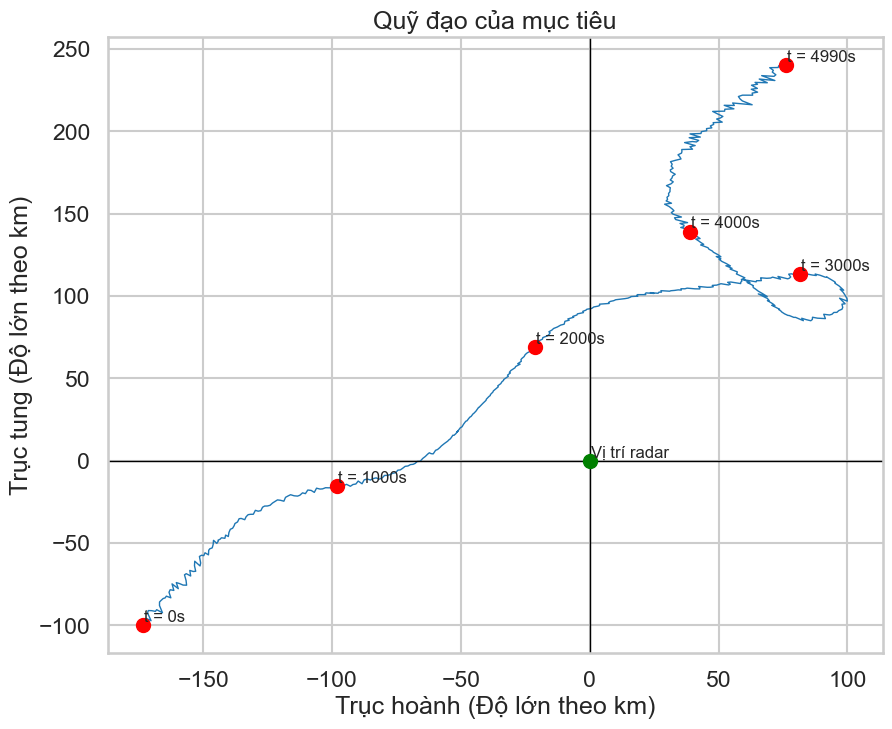

In [11]:
visualize_orbit.plot_orbit(df)